# Pre-processing Multiclass IDS (Collapsed 9 Classes) — v4

Fokus:
- Data explorer ringan (distribusi kelas, missingness, tipe fitur, korelasi ringkas)
- Cleaning: duplikat, durasi negatif, inf → NaN → median/drop
- Label collapsing ke 9 kelas (DoS, Web Attack, Brute Force, Port Scan, dll.)
- Feature engineering opsional (beberapa rasio sederhana)
- Pruning korelasi longgar (threshold 0.98)
- Downcast tipe numerik (hemat memori)
- Phase A subset (sampling BENIGN) untuk eksplorasi cepat
- Simpan artefak preprocessing untuk modeling

In [1]:
# !pip install pandas numpy scikit-learn joblib seaborn matplotlib
import pandas as pd
import numpy as np
from pathlib import Path
import json, joblib
import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

OUTPUT_DIR = Path("./artifacts_multiclass_collapsed_v4")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Konfigurasi pre-processing
NAN_DROP_PCT_THRESHOLD = 0.001  # <0.1% → drop baris
HIGH_CORR_THRESHOLD = 0.98      # lebih longgar agar sinyal gabungan tidak hilang
PHASE_A_BENIGN_TARGET = 150_000 # sampling BENIGN untuk Phase A
FE_ENABLE = True                # feature engineering sederhana (boleh set False kalau mau minimalis)

## 0. Sumber Data (CIC-IDS2017, versi CSV yang sama seperti sebelumnya)

In [2]:
RAW_FILES = [
    "https://storage.googleapis.com/mlskripsi/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv",
    "https://storage.googleapis.com/mlskripsi/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv",
    "https://storage.googleapis.com/mlskripsi/Friday-WorkingHours-Morning.pcap_ISCX.csv",
    "https://storage.googleapis.com/mlskripsi/Monday-WorkingHours.pcap_ISCX.csv",
    "https://storage.googleapis.com/mlskripsi/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv",
    "https://storage.googleapis.com/mlskripsi/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv",
    "https://storage.googleapis.com/mlskripsi/Tuesday-WorkingHours.pcap_ISCX.csv",
    "https://storage.googleapis.com/mlskripsi/Wednesday-workingHours.pcap_ISCX.csv"
]

def load_and_concat(urls):
    dfs = []
    for u in urls:
        try:
            df_part = pd.read_csv(u)
            df_part['source_file'] = u.rsplit('/', 1)[-1]
            dfs.append(df_part)
        except Exception as e:
            print(f"Gagal load {u}: {e}")
    if not dfs:
        raise ValueError("Tidak ada file termuat")
    return pd.concat(dfs, ignore_index=True)

raw_df = load_and_concat(RAW_FILES)
print("Shape awal:", raw_df.shape)
raw_df.head(3)

Shape awal: (2830743, 80)


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,source_file
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv


## 1. Data Explorer Ringan (awal)
- Tipe data dan contoh nilai
- Persentase missing per kolom (top 10)
- Distribusi awal label (raw)

In [3]:
raw_df.columns = [c.replace('\ufeff','').strip() for c in raw_df.columns]
print("Info ringkas:")
print(raw_df.dtypes.head(10))

label_candidates = [c for c in raw_df.columns if c.lower()== 'label']
if not label_candidates:
    raise ValueError("Kolom label tidak ditemukan.")
LABEL_COL = label_candidates[0]

print("Top 10 kolom dengan missing tertinggi:")
miss_pct = raw_df.isna().mean().sort_values(ascending=False)
print(miss_pct.head(10))

print("Distribusi label (raw, top 20):")
print(raw_df[LABEL_COL].value_counts().head(20))

Info ringkas:
Destination Port                 int64
Flow Duration                    int64
Total Fwd Packets                int64
Total Backward Packets           int64
Total Length of Fwd Packets      int64
Total Length of Bwd Packets      int64
Fwd Packet Length Max            int64
Fwd Packet Length Min            int64
Fwd Packet Length Mean         float64
Fwd Packet Length Std          float64
dtype: object
Top 10 kolom dengan missing tertinggi:
Flow Bytes/s                   0.00048
Destination Port               0.00000
Total Fwd Packets              0.00000
Flow Duration                  0.00000
Total Length of Fwd Packets    0.00000
Total Length of Bwd Packets    0.00000
Fwd Packet Length Max          0.00000
Total Backward Packets         0.00000
Fwd Packet Length Min          0.00000
Fwd Packet Length Mean         0.00000
dtype: float64
Distribusi label (raw, top 20):
Label
BENIGN                        2273097
DoS Hulk                       231073
PortScan                

## 2. Normalisasi Kolom & Cleaning Awal

In [4]:
df = raw_df.copy()
df.columns = [c.replace('\ufeff','').strip() for c in df.columns]
label_candidates = [c for c in df.columns if c.lower() == 'label']
LABEL_COL = label_candidates[0]
print("Kolom label:", LABEL_COL)

# Hapus duplikat
dups = df.duplicated().sum()
df = df.drop_duplicates()
print("Duplikat dihapus:", dups)

# Hapus durasi negatif
duration_cols = [c for c in df.columns if ('Flow' in c and 'Dur' in c) or 'Duration' in c]
removed_total = 0
for dc in duration_cols:
    neg = (pd.to_numeric(df[dc], errors='coerce') < 0).sum()
    if neg > 0:
        before = len(df)
        df = df[pd.to_numeric(df[dc], errors='coerce') >= 0]
        removed_total += (before - len(df))
        print(f"Menghapus {before - len(df)} baris dengan {dc} negatif")
print("Total baris dihapus karena durasi negatif:", removed_total)
print("Shape setelah cleaning awal:", df.shape)

# Replace inf/-inf -> NaN kemudian tangani missing
df = df.replace([np.inf, -np.inf], np.nan)

def handle_missing(dframe, drop_threshold=NAN_DROP_PCT_THRESHOLD):
    cols_nan = [c for c in dframe.columns if dframe[c].isna().any()]
    for col in cols_nan:
        pct = dframe[col].isna().mean()
        if pct <= drop_threshold:
            before = len(dframe)
            dframe = dframe[~dframe[col].isna()]
            print(f"Drop baris NaN kolom {col}: {before - len(dframe)}")
        else:
            med = pd.to_numeric(dframe[col], errors='coerce').median()
            dframe[col] = pd.to_numeric(dframe[col], errors='coerce').fillna(med)
    return dframe

df = handle_missing(df)
print("Missing value selesai. Shape:", df.shape)

Kolom label: Label
Duplikat dihapus: 256479
Menghapus 113 baris dengan Flow Duration negatif
Total baris dihapus karena durasi negatif: 113
Shape setelah cleaning awal: (2574151, 80)
Drop baris NaN kolom Flow Bytes/s: 1624
Drop baris NaN kolom Flow Packets/s: 0
Missing value selesai. Shape: (2572527, 80)


## 3. Label Collapsing ke 9 Kelas (sesuai mapping)

In [5]:
import re
import unicodedata
import pandas as pd

# Target akhir 5 kelas (network-only sesuai permintaan):
# BENIGN, DDoS, DoS, Port Scan, Brute Force

RAW_BASE_MAP = {
    'benign': 'BENIGN',
    'ddos': 'DDoS',
    'portscan': 'Port Scan',
    'port scan': 'Port Scan',  # jaga-jaga kalau sudah diubah
    'ftp-patator': 'Brute Force',
    'ssh-patator': 'Brute Force',
    # Catatan: 'bot', 'infiltration', 'heartbleed', 'web attack' tidak lagi dipetakan ke target,
    # sehingga akan terdrop pada langkah filter TARGET_LABELS.
}

def normalize_label(text: str) -> str:
    if not isinstance(text, str):
        text = str(text)
    # Unicode normalization
    t = unicodedata.normalize('NFKD', text)
    # Ganti karakter dash aneh ke '-'
    t = t.replace('–','-').replace('—','-').replace('�','-')
    # Hilangkan leading/trailing whitespace
    t = t.strip()
    # Collapse multiple spaces
    t = re.sub(r'\s+', ' ', t)
    # Lower-case
    t = t.lower()
    return t

def collapse_rule(norm_text: str) -> str:
    # Langsung cek mapping dasar
    if norm_text in RAW_BASE_MAP:
        return RAW_BASE_MAP[norm_text]

    # Aturan keluarga DoS
    # Contoh raw: 'DoS Hulk', 'DoS GoldenEye', 'DoS Slowloris', 'DoS Slowhttptest'
    # Setelah normalisasi: 'dos hulk', 'dos goldeneye', dll.
    if norm_text.startswith('dos '):
        return 'DoS'
    # Kadang format 'dos-slowloris' jika ada ganti dash → tangani juga
    if norm_text.startswith('dos-'):
        return 'DoS'

    # Brute Force dari Patator (fallback bila ada varian lain berisi kata 'patator')
    if 'patator' in norm_text:
        return 'Brute Force'

    # Port Scan fallback
    if 'portscan' in norm_text:
        return 'Port Scan'
    if 'port scan' in norm_text:
        return 'Port Scan'

    # Penting: Jangan lagi memetakan 'web attack', 'bot', 'infiltration', 'heartbleed' ke target
    # sehingga keduanya akan tetap bernilai mentah dan nantinya ter-filter keluar.

    # Jika tidak cocok, kembalikan label asli (nanti terlihat sebagai unmapped)
    return norm_text

def collapse_labels(df, label_col):
    df['Label_original'] = df[label_col]
    normed = df[label_col].apply(normalize_label)
    collapsed = []
    for raw, norm in zip(df[label_col].values, normed.values):
        final_lab = collapse_rule(norm)
        collapsed.append(final_lab)
    df['Label_collapsed'] = collapsed

    # Target set hanya 5 kelas (lower-case untuk pengecekan unmapped)
    target_set = set(['benign','ddos','dos','port scan','brute force'])

    # Normalisasi kembali nilai collapsed untuk cek unmapped
    norm_collapsed = [normalize_label(c) for c in df['Label_collapsed'].values]
    unmapped_mask = [nc not in target_set for nc in norm_collapsed]
    if any(unmapped_mask):
        problematic = pd.Series(df.loc[unmapped_mask,'Label_original']).value_counts()
        print("INFO: Ada label yang tidak ditangani rule (akan terdrop pada filter ke 5 kelas):")
        print(problematic.head(30))
    return df

# Jalankan collapse
df = collapse_labels(df, LABEL_COL)

# Rekonstruksi label_map dari label_collapsed yang sudah final (hanya 5 kelas)
# Filter hanya yang di target (drop lainnya)
TARGET_LABELS = ['BENIGN','DDoS','DoS','Port Scan','Brute Force']

# Standarisasi kapital sesuai target
standardized = []
for lab in df['Label_collapsed']:
    ln = normalize_label(lab)
    if ln == 'dos':
        standardized.append('DoS')
    elif ln == 'ddos':
        standardized.append('DDoS')
    elif ln == 'benign':
        standardized.append('BENIGN')
    elif ln == 'port scan':
        standardized.append('Port Scan')
    elif ln == 'brute force':
        standardized.append('Brute Force')
    else:
        # Label di luar target (mis. bot, web attack, infiltration, heartbleed, atau label mentah lainnya)
        # tetap disimpan sementara lalu akan difilter keluar.
        standardized.append(lab)

df['Label_collapsed'] = standardized

# Cek apakah ada label di luar target
extra_labels = sorted([l for l in df['Label_collapsed'].unique() if l not in TARGET_LABELS])
if extra_labels:
    print("INFO: Label di luar target (akan di-drop):", extra_labels)

# Drop baris yang labelnya di luar TARGET_LABELS
df = df[df['Label_collapsed'].isin(TARGET_LABELS)].copy()

# Encode
label_map = {lab:i for i,lab in enumerate(TARGET_LABELS)}
inv_label_map = {v:k for k,v in label_map.items()}
df['Label_encoded'] = df['Label_collapsed'].map(label_map)

print("Distribusi final collapsed (5 kelas):")
print(df['Label_collapsed'].value_counts())
print("Jumlah kelas final:", len(TARGET_LABELS))

INFO: Ada label yang tidak ditangani rule (akan terdrop pada filter ke 5 kelas):
Label_original
Bot                           1948
Web Attack � Brute Force      1470
Web Attack � XSS               652
Infiltration                    36
Web Attack � Sql Injection      21
Heartbleed                      11
Name: count, dtype: int64
INFO: Label di luar target (akan di-drop): ['bot', 'heartbleed', 'infiltration', 'web attack - brute force', 'web attack - sql injection', 'web attack - xss']
Distribusi final collapsed (5 kelas):
Label_collapsed
BENIGN         2146786
DoS             193745
DDoS            128014
Port Scan        90694
Brute Force       9150
Name: count, dtype: int64
Jumlah kelas final: 5


## 4. Data Explorer Tambahan (Collapsed)
- Distribusi kelas collapsed
- Missingness lagi (top 10)
- Korelasi ringkas (subset 25 fitur acak untuk heatmap agar ringan)

Distribusi kelas (collapsed):
Label_collapsed
BENIGN         2146786
DoS             193745
DDoS            128014
Port Scan        90694
Brute Force       9150
Name: count, dtype: int64
Missingness (top 10):
 Destination Port               0.0
Flow Duration                  0.0
Total Fwd Packets              0.0
Total Backward Packets         0.0
Total Length of Fwd Packets    0.0
Total Length of Bwd Packets    0.0
Fwd Packet Length Max          0.0
Fwd Packet Length Min          0.0
Fwd Packet Length Mean         0.0
Fwd Packet Length Std          0.0
dtype: float64


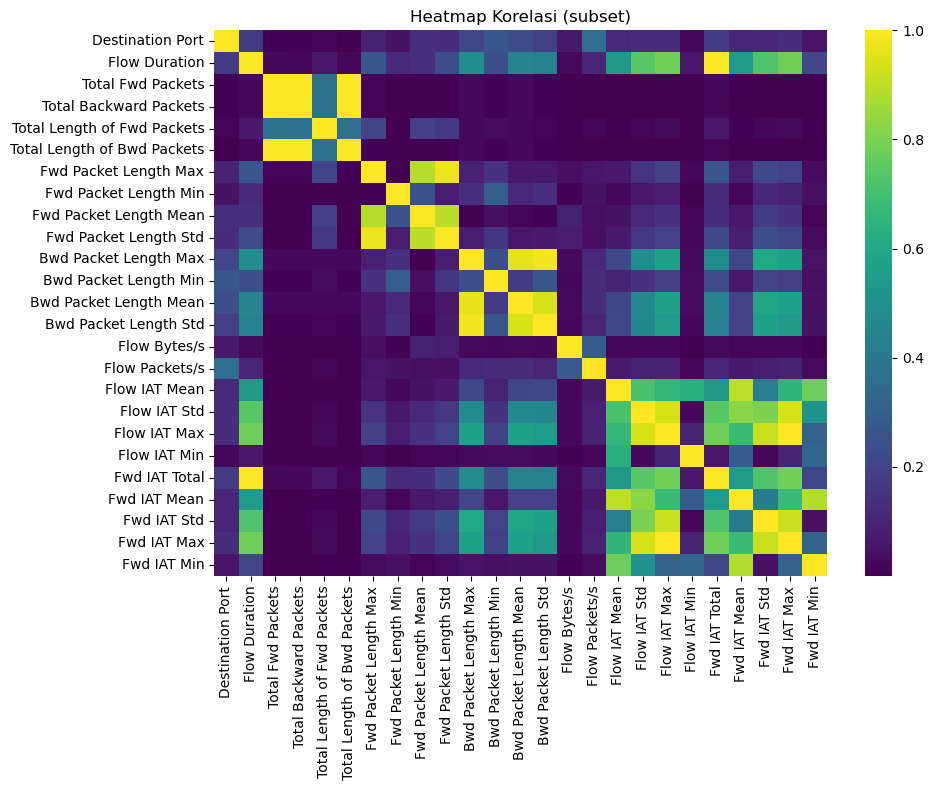

In [6]:
print("Distribusi kelas (collapsed):")
print(df['Label_collapsed'].value_counts())

miss_pct2 = df.isna().mean().sort_values(ascending=False)
print("Missingness (top 10):\n", miss_pct2.head(10))

# Heatmap korelasi ringan (subset kolom numerik)
num_cols_all = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c]) and c not in ['Label_encoded']]
subset_cols = num_cols_all[:25] if len(num_cols_all) > 25 else num_cols_all
if subset_cols:
    corr = df[subset_cols].corr().abs()
    plt.figure(figsize=(10,8))
    sns.heatmap(corr, cmap='viridis')
    plt.title('Heatmap Korelasi (subset)')
    plt.tight_layout()
    plt.show()

## 5. Feature Engineering (opsional, sederhana)

In [7]:
# if FE_ENABLE:
#     def safe_div(a,b):
#         try:
#             return a / b if float(b) != 0 else 0.0
#         except Exception:
#             return 0.0
#     # Nama kolom umum (sesuaikan jika berbeda)
#     if 'Total Length of Fwd Packets' in df.columns and 'Total Length of Bwd Packets' in df.columns:
#         df['Len_Asymmetry'] = (pd.to_numeric(df['Total Length of Fwd Packets'], errors='coerce') -
#                                 pd.to_numeric(df['Total Length of Bwd Packets'], errors='coerce')) / (
#                                 pd.to_numeric(df['Total Length of Fwd Packets'], errors='coerce') +
#                                 pd.to_numeric(df['Total Length of Bwd Packets'], errors='coerce') + 1)
#     if 'Total Fwd Packets' in df.columns and 'Total Backward Packets' in df.columns:
#         df['Dir_Packet_Ratio'] = (pd.to_numeric(df['Total Fwd Packets'], errors='coerce') + 1) / 
#                                   (pd.to_numeric(df['Total Backward Packets'], errors='coerce') + 1)

#     # Flow duration untuk rate
#     flow_dur_cols = [c for c in df.columns if 'Flow Duration' in c]
#     if flow_dur_cols:
#         dc = flow_dur_cols[0]
#         if 'Total Fwd Packets' in df.columns:
#             df['Fwd_Pkts_Rate'] = pd.to_numeric(df['Total Fwd Packets'], errors='coerce') / (pd.to_numeric(df[dc], errors='coerce') + 1)
#         if 'Total Backward Packets' in df.columns:
#             df['Bwd_Pkts_Rate'] = pd.to_numeric(df['Total Backward Packets'], errors='coerce') / (pd.to_numeric(df[dc], errors='coerce') + 1)

# print("FE selesai:", FE_ENABLE)

## 6. Downcast Numerik & Seleksi Fitur (Pruning Korelasi 0.98)

In [8]:
# Downcast numerik
for c in df.columns:
    if c in ['Label_collapsed','Label_original','source_file']:
        continue
    if pd.api.types.is_float_dtype(df[c]):
        df[c] = pd.to_numeric(df[c], errors='coerce').astype('float32')
    elif pd.api.types.is_integer_dtype(df[c]):
        df[c] = pd.to_numeric(df[c], errors='coerce').astype('int32', errors='ignore')

# Pilih fitur numerik saja (kecuali label dan kolom meta)
EXCLUDE_BASE = {LABEL_COL,'Label_encoded','Label_collapsed','Label_original','source_file','Flow ID','Timestamp','Source IP','Destination IP','SimillarHTTP',' Fwd Header Length.1',' Source IP',' Destination IP'}
candidate_cols = [c for c in df.columns if c not in EXCLUDE_BASE]
numeric_feature_cols = [c for c in candidate_cols if pd.api.types.is_numeric_dtype(df[c])]

def prune_high_corr(df_num, threshold=HIGH_CORR_THRESHOLD):
    corr = df_num.corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    drop_cols = [col for col in upper.columns if any(upper[col] > threshold)]
    kept = [c for c in df_num.columns if c not in drop_cols]
    return kept, drop_cols

kept_cols, dropped_cols = prune_high_corr(df[numeric_feature_cols], HIGH_CORR_THRESHOLD)
feature_cols = kept_cols
print("Total fitur numerik sebelum prune:", len(numeric_feature_cols))
print("Dibuang karena korelasi tinggi:", len(dropped_cols))
print("Total fitur final:", len(feature_cols))

Total fitur numerik sebelum prune: 78
Dibuang karena korelasi tinggi: 20
Total fitur final: 58


## 7. Sampling Phase A (Subset Eksplorasi)

In [9]:
benign_id = label_map.get('BENIGN')
if benign_id is None:
    raise ValueError("Label BENIGN tidak ditemukan dalam label_map.")
benign_df = df[df['Label_encoded']==benign_id]
attack_df = df[df['Label_encoded']!=benign_id]
if len(benign_df) > PHASE_A_BENIGN_TARGET:
    benign_sample = benign_df.sample(PHASE_A_BENIGN_TARGET, random_state=RANDOM_STATE)
else:
    benign_sample = benign_df.copy()
phaseA_df = pd.concat([benign_sample, attack_df], axis=0).sample(frac=1, random_state=RANDOM_STATE)
print("Full data shape:", df.shape)
print("Phase A shape:", phaseA_df.shape)
print("Distribusi Phase A (top 10):")
print(phaseA_df['Label_collapsed'].value_counts().head(10))

Full data shape: (2568389, 83)
Phase A shape: (571603, 83)
Distribusi Phase A (top 10):
Label_collapsed
DoS            193745
BENIGN         150000
DDoS           128014
Port Scan       90694
Brute Force      9150
Name: count, dtype: int64


## 8. Simpan Artefak Preprocessing

In [10]:
# ========== PATCH: Persiapan Artefak Mapping ==========

# 1. Jika kamu masih menggunakan mapping eksplisit (bukan rule-based),
# pastikan RAW_TO_COLLAPSE_MAP sudah didefinisikan. Contoh:
if 'RAW_TO_COLLAPSE_MAP' not in globals():
    # Jika memang pakai mapping manual (isi sesuai kebutuhan)
    RAW_TO_COLLAPSE_MAP = {
        'benign': 'BENIGN',
        'ddos': 'DDoS',
        'dos hulk': 'DoS',
        'dos goldeneye': 'DoS',
        'dos slowloris': 'DoS',
        'dos slowhttptest': 'DoS',
        'portscan': 'Port Scan',
        'ftp-patator': 'Brute Force',
        'ssh-patator': 'Brute Force',
        'bot': 'Bot',
        'web attack - brute force': 'Web Attack',
        'web attack - xss': 'Web Attack',
        'web attack - sql injection': 'Web Attack',
        'web attack � brute force': 'Web Attack',
        'web attack � xss': 'Web Attack',
        'web attack � sql injection': 'Web Attack',
        'infiltration': 'Infiltration',
        'heartbleed': 'Heartbleed'
    }

# 2. Buat mapping antara label original (apa adanya di CSV) dengan label setelah collapse.
# Drop duplikat agar satu original hanya punya satu collapsed.
original_to_collapsed_df = df[['Label_original','Label_collapsed']].drop_duplicates()

# Jika ada original yang (secara aneh) collapse ke lebih dari satu label (harusnya tidak), bisa dicek:
dup_check = original_to_collapsed_df['Label_original'].value_counts()
if (dup_check > 1).any():
    print("WARNING: Ada Label_original yang mapping ke >1 Label_collapsed. Harap dicek manual.")

original_to_collapsed = dict(zip(original_to_collapsed_df['Label_original'], original_to_collapsed_df['Label_collapsed']))

# 3. Perbarui label_map / inv_label_map (pastikan sudah dibuat sebelumnya)
labels_unique = sorted(df['Label_collapsed'].unique())
label_map = {lab:i for i,lab in enumerate(labels_unique)}
inv_label_map = {v:k for k,v in label_map.items()}
df['Label_encoded'] = df['Label_collapsed'].map(label_map)

print("Labels final:", labels_unique)
print("Total kelas:", len(labels_unique))
print("Distribusi final (top):")
print(df['Label_collapsed'].value_counts().head(20))

Labels final: ['BENIGN', 'Brute Force', 'DDoS', 'DoS', 'Port Scan']
Total kelas: 5
Distribusi final (top):
Label_collapsed
BENIGN         2146786
DoS             193745
DDoS            128014
Port Scan        90694
Brute Force       9150
Name: count, dtype: int64


In [11]:
joblib.dump({
    'full_df': df,
    'phaseA_df': phaseA_df,
    'label_map': label_map,
    'inv_label_map': inv_label_map,
    'label_col': 'Label_collapsed',
    'original_to_collapsed': RAW_TO_COLLAPSE_MAP,
    'feature_cols': feature_cols
}, OUTPUT_DIR / 'lite_clean_data_collapsed.pkl')
print("Artefak preprocessing disimpan ke:", OUTPUT_DIR)

Artefak preprocessing disimpan ke: artifacts_multiclass_collapsed_v4
